In [51]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import datasets
import os
import SimpleITK as sitk
from radiomics import featureextractor, shape, shape2D
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score, recall_score, precision_score, f1_score, ConfusionMatrixDisplay
from collections import defaultdict
import datetime
import glob
import networkx as nx


In [52]:

marksheet_path = r'Data\marksheet.csv'
source_PI_CAI = r'Data/picai_public_images'
source_PI_CAI_whole_gland_Guerbet23 = r'Data/picai_public_images/anatomical_delineations/whole_gland/AI/Guerbet23'
source_PI_CAI_Human = r'Data/picai_public_images/csPCa_lesion_delineations/human_expert/resampled'

def find_t2W_files(dir, combined_ids, fileinfo):
    dir = os.path.normpath(dir)
    t2w_file_paths = []

    for subdir, dirs, files in os.walk(dir):
        subdir = os.path.normpath(subdir)
        for file in files:
            if any(file.endswith(combined_id + fileinfo) for combined_id in combined_ids):
                t2w_file_paths.append(os.path.join(subdir, file))

    return t2w_file_paths

def preprocess_data(marksheet_df):
    print(f"Initial dataset length: {len(marksheet_df)}")

    # 1. Drop data with missing values in the column "PSA" or "Volume"
    marksheet_df = marksheet_df.dropna(subset=['psa', 'prostate_volume'])
    print(f"Dataset length after dropping rows with missing data: {len(marksheet_df)}")
    
    # 2. Filter out patients with no biopsy
    biopsy_filter = marksheet_df['histopath_type'].isin(['MRBx', 'SysBx', 'SysBx+MRBx'])
    marksheet_df = marksheet_df[biopsy_filter]
    print(f"Dataset length after filtering biopsies: {len(marksheet_df)}")

    # 3. Convert case_csPCa to binary (1: True, 0: False)
    marksheet_df['case_csPCa'] = marksheet_df['case_csPCa'].apply(lambda x: 1 if x.upper() == 'Yes' else 0)
    
    # Combined ids for use as a unique identifier
    sorted_patient_id = marksheet_df['patient_id']
    sorted_study_id = marksheet_df['study_id']
    combined_ids = sorted_patient_id.astype(str) + '_' + sorted_study_id.astype(str)

    return marksheet_df, combined_ids

def save_df(df, dir, filename, gland_type, date=None):
    if date is None:
        date = datetime.date.today().strftime("%Y%m%d")
    
    path = os.path.join(dir, f"{filename}_{gland_type}_{date}.csv")
    df.to_csv(path, index=False)
    print(f"File saved as {path}")


In [53]:
marksheet_df = pd.read_csv(marksheet_path)
Preprocessed_marksheet_df, combined_ids = preprocess_data(marksheet_df)
save_df(Preprocessed_marksheet_df, 'Data', 'Preprocessed_marksheet', 'all')
Preprocessed_marksheet_df


Initial dataset length: 1500
Dataset length after dropping rows with missing data: 1439
Dataset length after filtering biopsies: 945
File saved as Data\Preprocessed_marksheet_all_20250210.csv


,patient_id,study_id,mri_date,patient_age,psa,psad,prostate_volume,histopath_type,lesion_GS,lesion_ISUP,case_ISUP,case_csPCa,center
0,10000,1000000,2019-07-02,73,7.70,NaN,55.0,MRBx,0+0,0,0,0,PCNN
3,10003,1000003,2019-04-05,72,13.00,NaN,71.5,SysBx,0+0,0,0,0,ZGT
4,10004,1000004,2020-10-21,67,8.00,0.10,78.0,SysBx+MRBx,"0+0,0+0","0,0",0,0,RUMC
5,10005,1000005,2012-07-18,64,12.10,0.24,51.0,MRBx,"4+3,0+0","3,0",3,0,RUMC
6,10006,1000006,2020-10-23,73,6.20,0.23,27.0,SysBx+MRBx,"0+0,3+3","0,1",1,0,ZGT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,11471,1001495,2012-08-25,71,12.50,0.21,62.0,MRBx,"3+4,N/A,3+3","2,1",2,0,RUMC
1496,11472,1001496,2019-06-28,81,5.28,0.12,44.0,SysBx+MRBx,3+4,2,2,0,RUMC
1497,11473,1001497,2017-09-24,56,29.60,0.34,87.0,MRBx,0+0,0,0,0,RUMC
1498,11474,1001498,2016-05-03,71,12.00,NaN,83.0,MRBx,3+3,1,1,0,PCNN


In [54]:
def median_iqr(series):
    return f"{series.median():.2f} ({series.quantile(0.25):.2f}-{series.quantile(0.75):.2f})"

def calculate_psad(df):
    mask = df['psad'].isna() & df['psa'].notna() & df['prostate_volume'].notna()
    df.loc[mask, 'psad'] = (df.loc[mask, 'psa'] / df.loc[mask, 'prostate_volume']).round(2)
    
    return df

def generate_summary_table(df):
    N = len(df)
    age = df['patient_age']
    psa = df['psa']
    prostate_volume = df['prostate_volume']
    psad = calculate_psad(df)['psad']
    
    age_mean_std = f"{age.mean():.2f},\u2009+-\u2009 {age.std():.2f}"
    psa_median_iqr = median_iqr(psa)
    psad_median_iqr = median_iqr(psad)
    prostate_volume_median_std = f"{prostate_volume.median():.2f},\u2009+-\u2009 {prostate_volume.std():.2f}"


    vol_35 = prostate_volume[prostate_volume < 35].shape[0]
    vol_35_50 = prostate_volume[(prostate_volume >= 35) & (prostate_volume < 50)].shape[0]
    vol_50 = prostate_volume[prostate_volume >= 50].shape[0]

    biopsy_counts = df['histopath_type'].value_counts()
    biopsy_types = {
        'MRBx': biopsy_counts.get('MRBx', 0),
        'SysBx': biopsy_counts.get('SysBx', 0),
        'SysBx+MRBx': biopsy_counts.get('SysBx+MRBx', 0)
    }

    gleason_7_low = df[df["lesion_GS"] == "3+3"].shape[0]
    gleason_7_high = df[df["lesion_GS"].isin(["3+4", "4+3", "4+4", "5+4", "4+5", "5+5"])].shape[0]
    negative_biopsy = df[df["lesion_GS"] == "0+0"].shape[0]

    table_data = {
        'Age(Years)': age_mean_std,
        'PSA(ng/ml)': psa_median_iqr,
        'PSAD(ng/ml^2)': psad_median_iqr,
        'Prostate Volume(ml)': prostate_volume_median_std,
        "< 35 mL": f"{vol_35} ({(vol_35 / len(df)) * 100:.2f}%)",
        "35 - 50 mL": f"{vol_35_50} ({(vol_35_50 / len(df)) * 100:.2f}%)",
        "> 50 mL": f"{vol_50} ({(vol_50 / len(df)) * 100:.2f}%)",
        "Biopsy type": "".join([f"{k}: {v} ({(v / len(df)) * 100:.2f}%)" for k, v in biopsy_types.items()]),
        "Biopsy results:": "",
        "Negative:": f"{negative_biopsy} ({(negative_biopsy / len(df)) * 100:.2f}%)",
        "Gleason score ≤7:": f"{gleason_7_low} ({(gleason_7_low / len(df)) * 100:.2f}%)",
        "Gleason score >7:": f"{gleason_7_high} ({(gleason_7_high / len(df)) * 100:.2f}%)",
    }
    table_df = pd.DataFrame.from_dict(table_data, orient='index', columns=[f'Patients ({N})'])
    return table_df
summary_table = generate_summary_table(Preprocessed_marksheet_df)
print(summary_table)


                                                        Patients (945)
Age(Years)                                             66.47, +-  7.05
PSA(ng/ml)                                           9.00 (6.10-14.00)
PSAD(ng/ml^2)                                         0.18 (0.11-0.28)
Prostate Volume(ml)                                   51.00, +-  31.49
< 35 mL                                                   197 (20.85%)
35 - 50 mL                                                245 (25.93%)
> 50 mL                                                   503 (53.23%)
Biopsy type          MRBx: 529 (55.98%)SysBx: 211 (22.33%)SysBx+MRB...
Biopsy results:                                                       
Negative:                                                 257 (27.20%)
Gleason score ≤7:                                         124 (13.12%)
Gleason score >7:                                         221 (23.39%)


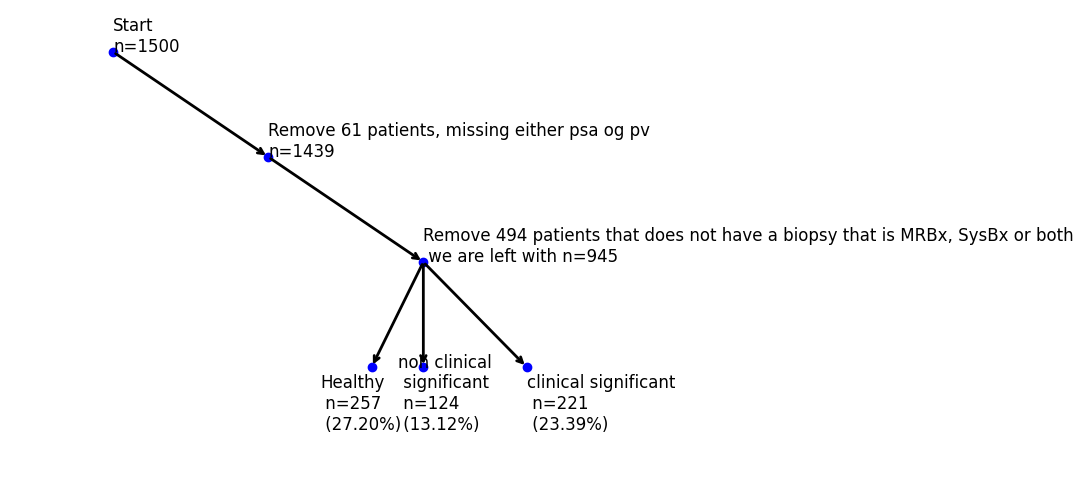

In [55]:
df = Preprocessed_marksheet_df
gleason_7_low = df[df["lesion_GS"] == "3+3"].shape[0]
gleason_7_high = df[df["lesion_GS"].isin(["3+4", "4+3", "4+4", "5+4", "4+5", "5+5"])].shape[0]
negative_biopsy = df[df["lesion_GS"] == "0+0"].shape[0]

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot([0.2, 0.5, 0.8, 0.7, 0.8, 1], [2, 1.5, 1, 0.5, 0.5, 0.5], 'o', color='blue')
ax.annotate("", xy=(0.5, 1.5), xytext=(0.2, 2), arrowprops=dict(arrowstyle="->", lw=2))
ax.annotate("", xy=(0.8, 1), xytext=(0.5, 1.5), arrowprops=dict(arrowstyle="->", lw=2))
ax.annotate("", xy=(0.7, 0.5), xytext=(0.8, 1), arrowprops=dict(arrowstyle="->", lw=2))
ax.annotate("", xy=(0.8, 0.5), xytext=(0.8, 1), arrowprops=dict(arrowstyle="->", lw=2))
ax.annotate("", xy=(1, 0.5), xytext=(0.8, 1), arrowprops=dict(arrowstyle="->", lw=2))

ax.text(0.2, 2, "Start\nn=1500", fontsize=12)
ax.text(0.5, 1.5, "Remove 61 patients, missing either psa og pv\nn=1439", fontsize=12)
ax.text(0.8, 1, "Remove 494 patients that does not have a biopsy that is MRBx, SysBx or both\n we are left with n=945", fontsize=12)
ax.text(0.6, 0.2, f"Healthy\n n={negative_biopsy} \n ({(negative_biopsy / len(df)) * 100:.2f}%)", fontsize=12)
ax.text(0.75, 0.2, f"non clinical \n significant \n n={gleason_7_low} \n ({(gleason_7_low / len(df)) * 100:.2f}%) " , fontsize=12)
ax.text(1, 0.2, f"clinical significant\n n={gleason_7_high} \n ({(gleason_7_high / len(df)) * 100:.2f}%)", fontsize=12)


ax.set_xlim(0, 1.2)
ax.set_ylim(0, 2.2)
ax.axis("off")

plt.show()

In [56]:
fileInfoT2w = '_t2w.mha'

fileInfo = '.nii.gz'
t2w_paths = find_t2W_files(source_PI_CAI, combined_ids, fileInfoT2w)
Guerbet23_nii_gz_paths = find_t2W_files(source_PI_CAI_whole_gland_Guerbet23, combined_ids, fileInfo)
Human_nii_gz_paths = find_t2W_files(source_PI_CAI_Human, combined_ids, fileInfo)

In [57]:
t2w_patient_ids = [path.split('\\')[-2] for path in t2w_paths]
Guerbet23_patient_ids = [path.split('\\')[-1].split("_")[0] for path in Guerbet23_nii_gz_paths]
Human_nii_gz_patient_ids = [path.split('\\')[-1].split("_")[0] for path in Human_nii_gz_paths]

t2w_df = pd.DataFrame({'patient_id': t2w_patient_ids, 'T2w_path': t2w_paths})
Guerbet23_df = pd.DataFrame({'Nii_gz_path': Guerbet23_nii_gz_paths, 'patient_id': Guerbet23_patient_ids})
Human_df = pd.DataFrame({'Nii_gz_path': Human_nii_gz_paths, 'patient_id': Human_nii_gz_patient_ids})

df_path_merged_Guerbet23 = pd.merge(t2w_df, Guerbet23_df, on='patient_id')
df_path_merged_Human = pd.merge(t2w_df, Human_df, on='patient_id')


Image shape: (31, 640, 640)


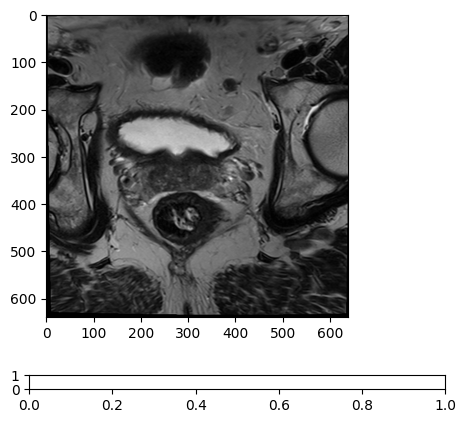

In [58]:
file_path = r"Data\picai_public_images\picai_public_images_fold0\10000\10000_1000000_t2w.mha"

image = sitk.ReadImage(file_path)
image_data = sitk.GetArrayFromImage(image)

print(f"Image shape: {image_data.shape}")

fig, ax = plt.subplots()
plt.subplots_adjust(bottom=0.25)

axlayer = plt.axes([0.25, 0.1, 0.65, 0.03])

ax.imshow(image_data[18, :, :], cmap='gray')

plt.show()

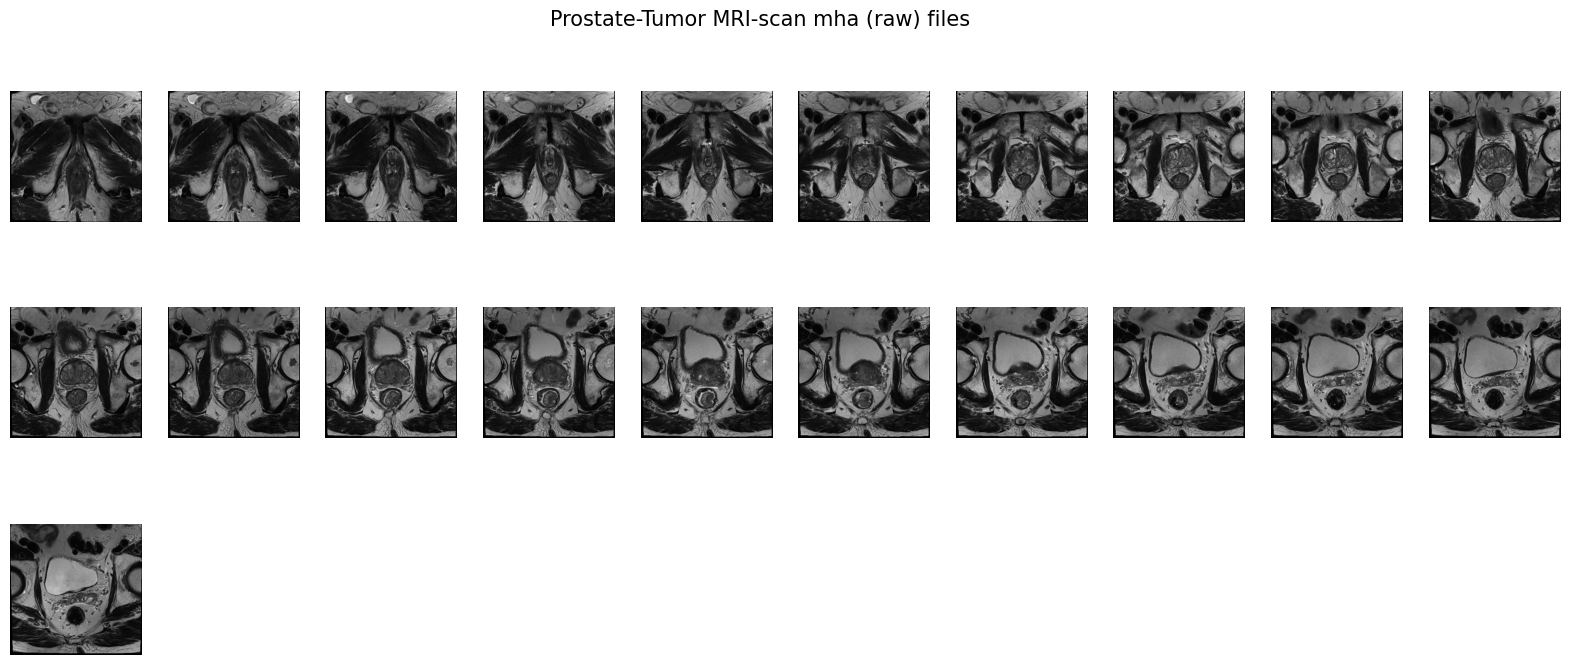

In [59]:
file_path = r"Data\picai_public_images\picai_public_images_fold1\10008\10008_1000008_t2w.mha"
image = sitk.ReadImage(file_path)
image_data = sitk.GetArrayFromImage(image)

if image_data.max() > 0:
    image_data = image_data / image_data.max()

num_slices = image_data.shape[0]

cols = 10
rows = int(np.ceil(num_slices / cols))

plt.figure(figsize=(20, rows * 2.5))
plt.gray()
plt.subplots_adjust(hspace=0.5)

for i in range(num_slices):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(image_data[i], cmap='gray')
    plt.axis('off')

plt.suptitle('Prostate-Tumor MRI-scan mha (raw) files', size=15)
plt.show()

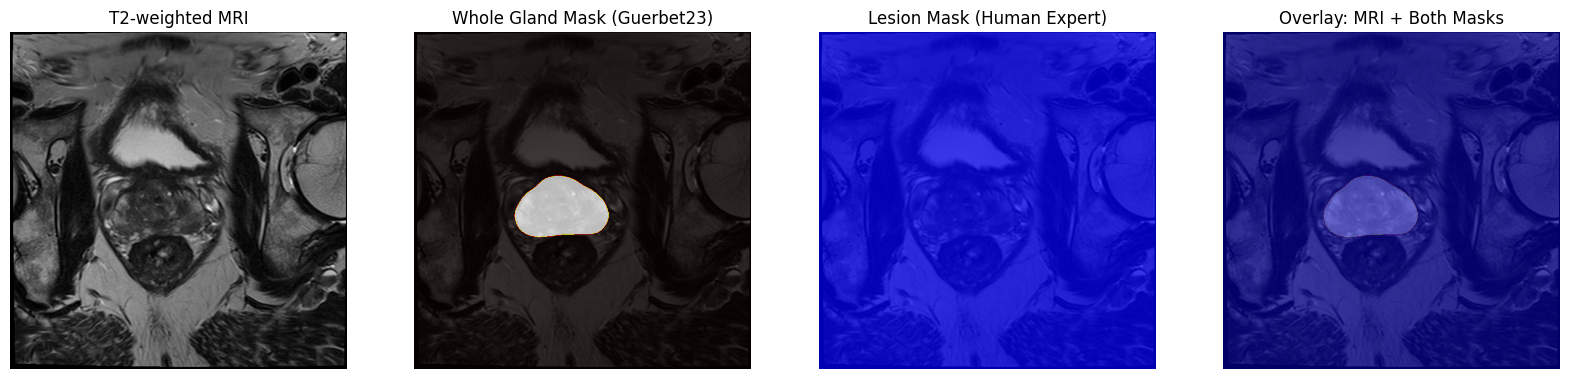

In [60]:
def load_nifti_image(file_path):
    img = sitk.ReadImage(file_path)
    return sitk.GetArrayFromImage(img) 

patient_id = df_path_merged_Guerbet23.iloc[0]['patient_id']  

t2w_path = df_path_merged_Guerbet23.iloc[0]['T2w_path']
guerbet23_mask_path = df_path_merged_Guerbet23.iloc[0]['Nii_gz_path']
human_mask_path = df_path_merged_Human.iloc[0]['Nii_gz_path']

t2w_image = load_nifti_image(t2w_path)
guerbet23_mask = load_nifti_image(guerbet23_mask_path)
human_mask = load_nifti_image(human_mask_path) 

t2w_image = t2w_image / np.max(t2w_image)

mid_slice = t2w_image.shape[0] // 2

fig, ax = plt.subplots(1, 4, figsize=(20, 5))

ax[0].imshow(t2w_image[mid_slice], cmap='gray')
ax[0].set_title("T2-weighted MRI")

ax[1].imshow(t2w_image[mid_slice], cmap='gray')
ax[1].imshow(guerbet23_mask[mid_slice], cmap='hot', alpha=0.7)
ax[1].set_title("Whole Gland Mask (Guerbet23)")

ax[2].imshow(t2w_image[mid_slice], cmap='gray')
ax[2].imshow(human_mask[mid_slice], cmap='winter', alpha=0.7)
ax[2].set_title("Lesion Mask (Human Expert)")

ax[3].imshow(t2w_image[mid_slice], cmap='gray')
ax[3].imshow(guerbet23_mask[mid_slice], cmap='hot', alpha=0.4)
ax[3].imshow(human_mask[mid_slice], cmap='winter', alpha=0.4)
ax[3].set_title("Overlay: MRI + Both Masks")

for a in ax:
    a.axis("off")

plt.show()

In [62]:
images_masks_list = []

for index, row in df_path_merged_Guerbet23.iterrows():
    patient_id = row['patient_id']

    t2w_path = row['T2w_path']
    guerbet23_mask_path = row['Nii_gz_path']
    human_row = df_path_merged_Human[df_path_merged_Human['patient_id'] == patient_id]

    if human_row.empty:
        print(f"Missing human mask for patient {patient_id}, skipping...")
        continue

    human_mask_path = human_row.iloc[0]['Nii_gz_path']

    if not (os.path.exists(t2w_path) and os.path.exists(guerbet23_mask_path) and os.path.exists(human_mask_path)):
        print(f"Missing file(s) for patient {patient_id}, skipping...")
        continue

    t2w_image = load_nifti_image(t2w_path)
    guerbet23_mask = load_nifti_image(guerbet23_mask_path)
    human_mask = load_nifti_image(human_mask_path)

    if np.max(t2w_image) > 0:
        t2w_image = t2w_image / np.max(t2w_image)

    mid_slice = t2w_image.shape[0] // 2

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(t2w_image[mid_slice], cmap='gray')
    ax.imshow(guerbet23_mask[mid_slice], cmap='hot', alpha=0.4)
    ax.imshow(human_mask[mid_slice], cmap='winter', alpha=0.4)
    ax.axis("off")
    ax.set_title(f"Patient {patient_id}")

    fig.canvas.draw()
    image_array = np.array(fig.canvas.renderer.buffer_rgba())
    images_masks_list.append((patient_id, image_array))

    plt.close(fig)

Missing human mask for patient 10029, skipping...
Missing human mask for patient 10400, skipping...
Missing human mask for patient 10459, skipping...
Missing human mask for patient 10501, skipping...
Missing human mask for patient 10515, skipping...
Missing human mask for patient 10550, skipping...
Missing human mask for patient 10562, skipping...
Missing human mask for patient 10565, skipping...
Missing human mask for patient 10679, skipping...
Missing human mask for patient 10701, skipping...
Missing human mask for patient 10753, skipping...
Missing human mask for patient 10760, skipping...
Missing human mask for patient 10772, skipping...
Missing human mask for patient 10775, skipping...
Missing human mask for patient 10862, skipping...
Missing human mask for patient 10956, skipping...
Missing human mask for patient 10993, skipping...
Missing human mask for patient 11045, skipping...
Missing human mask for patient 11067, skipping...
Missing human mask for patient 11095, skipping...


In [63]:
def find_significant_correlations(df, processed_subset, target_variable='case_csPCa', threshold=0.0):
    df['patient_id'] = df['patient_id'].astype(int)

    merge_df = pd.merge(processed_subset, df, left_on='patient_id', right_on='patient_id', how='left')
    merge_df.drop('patient_id', axis=1, inplace=True)
    correlation_matrix = merge_df.corr()
    absolute_correlation = correlation_matrix[target_variable].abs()
    significant_correlations = absolute_correlation[absolute_correlation > threshold].sort_values(ascending=False)
    
    
    return significant_correlations


def evaluate_model_perfomance(model, X_train, y_train, X_test, y_test, name=""):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_test_pred_proba = model.predict_proba(X_test)[:, 1]

    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
    auc_score = auc(fpr, tpr)

    classification_report_str = classification_report(y_test, y_test_pred)

    metrics = {
        f'AUC_{name}': auc_score,
        f'Accuracy_{name}': test_accuracy,
        f'Sensitivity_{name}': recall_score(y_test, y_test_pred),
        f'Specificity_{name}': recall_score(y_test, y_test_pred, pos_label=0),
        f'F! Score_{name}': f1_score(y_test, y_test_pred),
    }

    return train_accuracy, test_accuracy, classification_report_str, metrics, fpr, tpr

def print_mean_and_std(results_df):
    for i, row in results_df.iterrows():
        model_name = row['model']

        print(f"Model: {model_name}")
        print("Cross-validation metrics (Mean, Standard Deviation):")

        metrics = ['AUC', 'Accuracy', 'Sensitivity', 'Precision', 'F1 Score']
        for metric in metrics:
            mean_val, sd_val = row[metric]
            print(f"{metric}: Mean = {mean_val:.4f}, SD = {sd_val:.4f}")
        print("\n--------------------------------------------------")

    return results_df[['model'] + metrics]

def evaluate_confusion_matrix(model, X_test, y_test, ax=None, name="", threshold=0.5, display= False):

    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba >= threshold).astype(int)

    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

    if ax is not None:
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
        disp.plot(ax=ax)
        ax.set_title(name)
    
    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0.0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0.0

    metrics = {
        'Title:': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'TP': TP,
        'TN': TN,
        'FP': FP,
        'FN': FN
    }

    if display:
        print(f'Title: {name}')
        print(f'Accuracy: {accuracy:.4f}')
        print(f'Precision: {precision:.4f}')
        print(f'Recall: {recall:.4f}')
        print(f'F1 Score: {f1:.4f}')

    return metrics, cm

In [ ]:
df_file_path = r"Data\Preprocessed_marksheet_all_20250208.csv"
df = pd.read_csv(df_file_path)

params = ['patient_age', 'psa', 'prostate_volume']
#training_df = df[]
#training_df = training_df.join(df.set_index('patient_id'), on='patient_id')
X_simple = df[params]


simple_model = LogisticRegression()


SyntaxError: invalid syntax (1033161087.py, line 5)

In [ ]:
df_file_path = r"Data\Preprocessed_marksheet_all_20250208.csv"
df = pd.read_csv(df_file_path)

# unique_ids = df['patient_id'].unique()
# train_ids, test_ids = train_test_split(unique_ids, test_size=0.2, random_state=42)

# train_df = df[df['patient_id'].isin(train_ids)]
# test_df = df[df['patient_id'].isin(test_ids)]

# X_train = train_df.drop(columns=['psa', 'patient_id'])
# y_train = train_df['psa']
# X_test = test_df.drop(columns=['psa', 'patient_id'])
# y_test = test_df['psa']

# model = LogisticRegression()
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)
# mse = mean_squared_error(y_test, y_pred)
# print(f"Mean Squared Error: {mse}")
# r2 = r2_score(y_test, y_pred)
# print(f"R2 Score: {r2}")

